# Applied Machine Learning: Credit Card Approval Prediction

*By Daniel Deutsch and José Lucas Barretto*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# random state
random_state=42

## Data Processing

At this staage the goal is to read both datasets and adapt its content for our classification models.

### Processing raw data

#### Credit records

In [3]:
# Reads the dataset
df_credit_record = pd.read_csv("./datasets/credit_record.csv")

# Renames columns
df_credit_record.rename(columns=str.lower, inplace=True)

# Numericalize status
df_credit_record.replace({'status': {'X': 0, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}}, inplace=True)

# Calculates the metric
df_credit_record = df_credit_record.groupby('id')['status'].mean().reset_index()

# Sets the label
df_credit_record['is_good'] = 1*(df_credit_record['status'] <= 1)

#### Application Records

In [4]:
# Reads the dataset
df_application_record = pd.read_csv("./datasets/application_record.csv")

# Renames columns
df_application_record.rename(columns=str.lower, inplace=True)

# numericalyze and rename education level
df_application_record.replace({
    'name_education_type': {
        'Higher education': 4,
        'Academic degree': 4,
        'Incomplete higher': 3,
        'Secondary / secondary special': 2,
        'Lower secondary': 1, 
    }
}, inplace=True)
df_application_record.rename(columns={'name_education_type': 'education_level'}, inplace=True)

# transform days employed into is_unemployed
df_application_record['is_unemployed'] = 1*(df_application_record['days_employed'] > 0)

# drop uninteresting columns - birthday, days employed
df_application_record.drop(columns=['days_employed', 'days_birth'], inplace=True)

#### Merging data

In [5]:
df = pd.merge(df_credit_record, df_application_record, how='inner', on='id')

del df_credit_record, df_application_record

### Train-test split

In [6]:
# define categorical, numerical, and other interesting vars
categorical = [
    'code_gender', 
    'flag_own_car', 
    'flag_own_realty', 
    'name_income_type',
    'name_family_status', 
    'name_housing_type', 
    'flag_mobil', 
    'flag_work_phone',
    'flag_phone', 
    'flag_email',
    'occupation_type'
]

numerical = [
    'cnt_children',
    'amt_income_total',
    'cnt_fam_members'
]

other = [
    'is_unemployed',
    'education_level'
]

# define X and y datasets
X = df[categorical + numerical + other]
y = df['is_good']

# split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Processing features

In [7]:
# initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

In [8]:
# initialize scaler for numerical vars
scaler = StandardScaler()

# fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# transform scaler to test data
X_test_numerical = pd.DataFrame(scaler.transform(X_test[numerical]), index=X_test.index, columns=numerical)

In [9]:
# concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical, X_train[other]), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical, X_test[other]), axis=1)

## Modeling, Feature Selection, Explainability

### Random Forest

#### Training and Evaluating the Model

In [10]:
clf = RandomForestClassifier()

param_grid = {
    "n_estimators":[250, 300, 500],
    "max_depth":[500, 1000, 2000],
    "max_features":[5,10,20,X_train_normal.shape[1]]
}

clf = RandomForestClassifier()

clf_tuned = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=3,
)

clf_tuned.fit(X_train_normal, y_train)
clf_tuned.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.708 total time=   4.2s
[CV 2/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.681 total time=   4.3s
[CV 3/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.713 total time=   4.4s
[CV 3/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.711 total time=   5.0s
[CV 2/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.695 total time=   5.0s
[CV 1/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.702 total time=   5.1s
[CV 1/3] END max_depth=500, max_features=5, n_estimators=500;, score=0.708 total time=   8.1s
[CV 2/3] END max_depth=500, max_features=5, n_estimators=500;, score=0.702 total time=   8.2s
[CV 1/3] END max_depth=500, max_features=10, n_estimators=250;, score=0.697 total time=   5.0s
[CV 2/3] END max_depth=500, max_features=10, n_estimators=250;, score=0.687 total time=   5

RandomForestClassifier(max_depth=500, max_features=10, n_estimators=500)

In [12]:
pred = clf_tuned.best_estimator_.predict(X_test_normal)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.41      0.13      0.20       406
           1       0.97      0.99      0.98     10532

    accuracy                           0.96     10938
   macro avg       0.69      0.56      0.59     10938
weighted avg       0.95      0.96      0.95     10938



#### Feature Importance

##### Permutation Importance

In [13]:
feature_names = X_train_normal.columns

result = permutation_importance(
    clf_tuned.best_estimator_, X_test_normal, y_test, n_repeats=10, n_jobs=-1, random_state=random_state
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

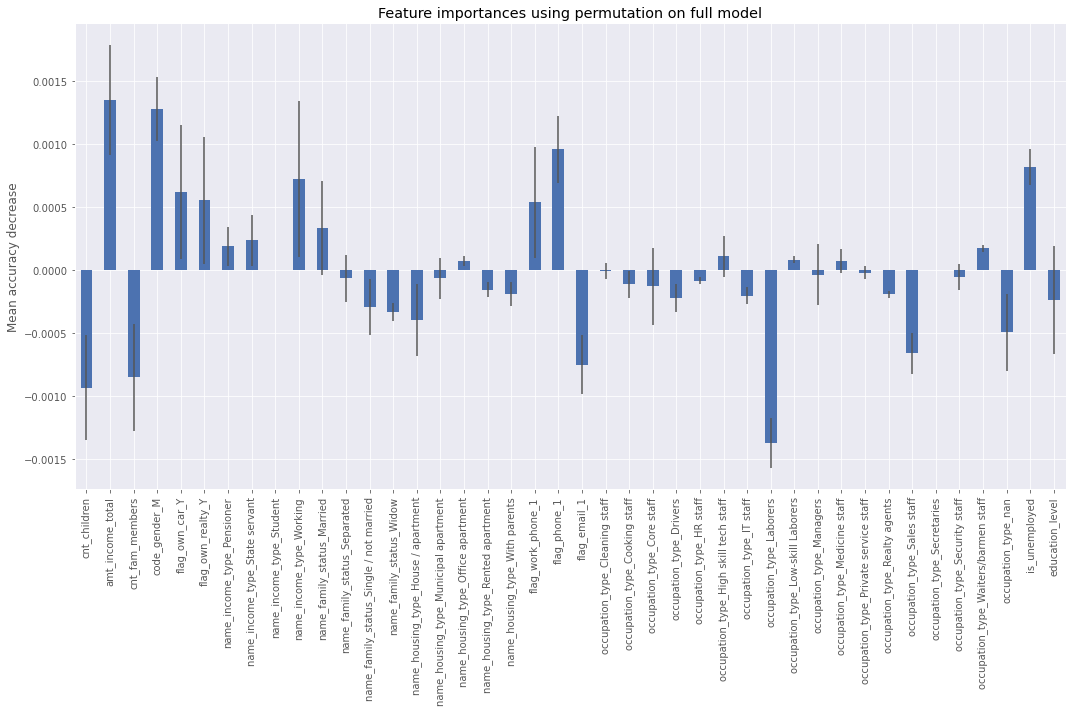

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

##### Synergy and Redundance